In [1]:
from tqdm import tqdm, trange

import torch
from torch.utils.data import DataLoader

from src.dataset.dataset import FurnitureFeatureDataset, FurnitureImageDataset
from src.dataset.dataloader import FixedStepsDataloader
from src.dataset.normalizer import StateActionNormalizer
from src.models.vision import get_encoder

import matplotlib.pyplot as plt

import zarr

/data/scratch/ankile/miniconda3/envs/rlgpu/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
obs_horizon = 2
batch_size = 1024

In [20]:
feature_dataset = FurnitureFeatureDataset(
    action_horizon=8,
    data_subset=None,
    obs_horizon=obs_horizon,
    pred_horizon=16,
    normalizer=StateActionNormalizer(),
    dataset_path="/data/scratch/ankile/furniture-data/data/processed/sim/feature_small/vip/one_leg/data_new_short.zarr",
)

Loading dataset of 16 episodes


In [21]:
image_dataset = FurnitureImageDataset(
    action_horizon=8,
    data_subset=None,
    obs_horizon=obs_horizon,
    pred_horizon=16,
    normalizer=StateActionNormalizer(),
    dataset_path="/data/scratch/ankile/furniture-data/data/processed/sim/image_small/one_leg/data_batch_32_short.zarr",
)

Loading dataset of 16 episodes


In [22]:
feature_loader = FixedStepsDataloader(
    feature_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
    persistent_workers=True,
    n_batches=10,
)
image_loader = FixedStepsDataloader(
    image_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
    persistent_workers=True,
    n_batches=10,
)

In [6]:
enc = get_encoder(
    encoder_name="vip", device="cuda", freeze=True, pretrained=True
).eval()

In [23]:
for feature_batch, image_batch in tqdm(
    zip(feature_loader, image_loader), total=len(feature_loader)
):
    if not (feature_batch["action"] == image_batch["action"]).all():
        print("Mismatch in action")
    if not (feature_batch["robot_state"] == image_batch["robot_state"]).all():
        print("Mismatch in robot_state")

    image1 = (
        image_batch["color_image1"]
        .reshape(batch_size * obs_horizon, 224, 224, 3)
        .cuda()
    )
    image2 = (
        image_batch["color_image2"]
        .reshape(batch_size * obs_horizon, 224, 224, 3)
        .cuda()
    )

    # Encode images and reshape back to (B, obs_horizon, encoding_dim)
    with torch.no_grad():
        features1 = enc(image1).reshape(batch_size, obs_horizon, -1).cpu()
        features2 = enc(image2).reshape(batch_size, obs_horizon, -1).cpu()

    # # Check that the features are the same
    # assert (features1 == feature_batch["feature1"]).all(), "Feature1 mismatch"
    # assert (features2 == feature_batch["feature2"]).all(), "Feature2 mismatch"

  0%|          | 0/10 [00:00<?, ?it/s]

Mismatch in robot_state


  0%|          | 0/10 [00:15<?, ?it/s]

KeyboardInterrupt



In [ ]:
torch.isclose(features1, feature_batch["feature1"], atol=1e-3).float().mean()

tensor(0.9262)

In [ ]:
torch.argmax(
    (features1[0, 1, :] - feature_batch["feature1"][0, 1, :])
    / feature_batch["feature1"][0, 1, :]
)

tensor(734)

In [ ]:
features1[0, 1, 734].item(), feature_batch["feature1"][0, 1, 734].item()

(-0.015898585319519043, -0.015264928340911865)

In [ ]:
features1.max(), feature_batch["feature1"].max()

(tensor(29.0551), tensor(29.0513))

In [ ]:
features1[:, :, 209].mean(), feature_batch["feature1"][:, :, 209].mean()

(tensor(-4.1594), tensor(-4.1698))

In [ ]:
(feature_batch["action"] == image_batch["action"]).all()

tensor(True)

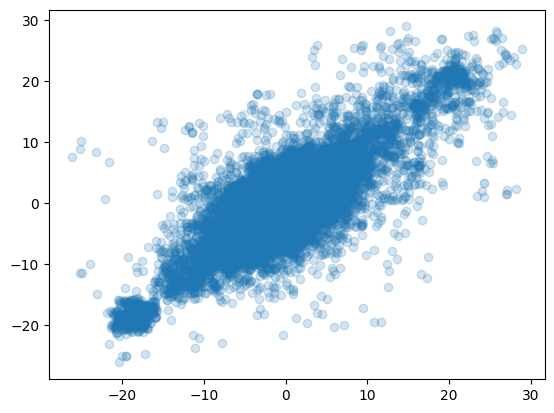

In [18]:
feature_flat = feature_batch["feature1"].flatten().numpy()
image_flat = features1.flatten().numpy()

plt.scatter(feature_flat, image_flat, alpha=0.1)

In [ ]:
(abs(feature_flat) > 10).mean() * 100

0.408935546875

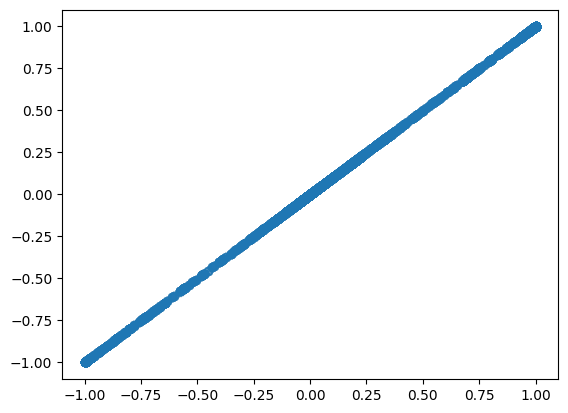

In [16]:
# Scatter plot for actions
feature_flat = feature_batch["action"].flatten().numpy()
image_flat = image_batch["action"].flatten().numpy()

plt.scatter(feature_flat, image_flat, alpha=0.1)

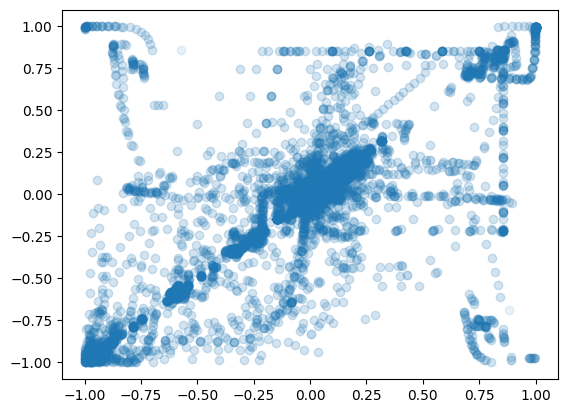

In [15]:
# Scatter plot for robot state
feature_flat = feature_batch["robot_state"].flatten().numpy()
image_flat = image_batch["robot_state"].flatten().numpy()

plt.scatter(feature_flat, image_flat, alpha=0.1)

In [26]:
image_batch["color_image1"].shape

torch.Size([128, 2, 224, 224, 3])

In [29]:
feature_zarr = zarr.open(
    "/data/scratch/ankile/furniture-data/data/processed/sim/feature_small/vip/one_leg/data_new.zarr",
    mode="r",
)
image_zarr = zarr.open(
    "/data/scratch/ankile/furniture-data/data/processed/sim/image_small/one_leg/data_batch_32.zarr",
    mode="r",
)

In [30]:
for feature_robot_state, image_robot_state in tqdm(
    zip(feature_zarr["robot_state"], image_zarr["robot_state"]), total=len(feature_zarr)
):
    assert (feature_robot_state == image_robot_state).all(), "Robot state mismatch"

590it [00:00, 22341.55it/s]          


AssertionError: Robot state mismatch

In [34]:
feature_robot_state

array([ 0.5672798 ,  0.05542726,  0.12392187,  0.893298  ,  0.44938526,
       -0.00800878,  0.00271298,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.065     ], dtype=float32)

In [32]:
image_robot_state

array([ 4.90785897e-01,  1.15334250e-01,  4.84694839e-02, -7.77453363e-01,
        6.28883779e-01,  5.28719602e-03,  6.58674212e-03,  2.01373734e-02,
       -1.85069349e-03,  1.11532165e-04, -2.36562099e-02, -8.61521065e-02,
       -1.55043411e+00,  2.54120138e-02], dtype=float32)

In [36]:
(feature_zarr["robot_state"][:] == image_zarr["robot_state"][:])

/tmp/ipykernel_1383974/4011430908.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  (feature_zarr["robot_state"][:] == image_zarr["robot_state"][:])


False

In [25]:
feature_batch = next(iter(feature_loader))
image_batch = next(iter(image_loader))

In [27]:
for i, (feature_state, image_state) in enumerate(
    zip(
        feature_batch["robot_state"].reshape(-1, 14),
        image_batch["robot_state"].reshape(-1, 14),
    )
):
    assert (feature_state == image_state).all(), f"Robot state mismatch at {i}"

(torch.Size([1024, 2, 14]), torch.Size([1024, 2, 14]))